Let's check the dataloader is working correctly

In [13]:
!pip install pandas
!pip install tensorboard
!pip install matplotlib 
!pip install avalanche-lib
!pip install torch
!pip install multipledispatch

  Obtaining dependency information for multipledispatch from https://files.pythonhosted.org/packages/51/c0/00c9809d8b9346eb238a6bbd5f83e846a4ce4503da94a4c08cb7284c325b/multipledispatch-1.0.0-py3-none-any.whl.metadata
Using cached multipledispatch-1.0.0-py3-none-any.whl (12 kB)


In [71]:
import sys
sys.path.append("../")
from custom_plugins import BatchSplitReplay, FixedBuffer
import data as data
from utils import get_eval_plugin, get_optimizer, get_model, train
from torch.nn import CrossEntropyLoss
from avalanche.training.templates import SupervisedTemplate
from avalanche.core import BaseSGDPlugin
from matplotlib import pyplot as plt
import numpy as np
import PIL
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms

In [128]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.2023, 1/0.1994, 1/0.2010 ]),
                                transforms.Normalize(mean = [ -0.4914, -0.4822, -0.4465 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

class DL_inspector(BaseSGDPlugin):
    def __init__(self):
        super().__init__()
        self.labels = []

    def get_image(self, tensor):
        to_pil_image(invTrans(tensor)).show()

    def before_training_epoch(self, strategy, *args, **kwargs):
        print(strategy.__dict__.keys())
        for i, batch in enumerate(strategy.dataloader):
            self.labels.append(batch[1].numpy())

    # def before_forward(self, strategy, *args, **kwargs):
    #     print("Before forward")
    #     print(strategy.mb_x.shape)
    #     print(strategy.mb_y)
    #     print(strategy.mb_task_id)
    #     raise Exception("Stop")

In [144]:
# HANDLE DEVICE
device = "cpu"

# GET DATA
scenario, buffer_data = data.get_data("SplitCIFAR10", "SplitCIFAR10", n_tasks=5, strategy={"name":"stratify", "percentage":0.8}) 

# CREATE MODEL
num_classes = len([item for sublist in scenario.original_classes_in_exp for item in sublist]) # so we set the output layer to the correct size
model = get_model("ResNet18", device, num_classes)

# CREATE OPTIMIZER
optimizer = get_optimizer("SGD", model, 0.1)

# DEFINE THE EVALUATION PLUGIN and LOGGERS
eval_plugin = get_eval_plugin("test", track_classes={0: [0,1,2,3,4,5,6,7,8,9]}) 

# SETUP OTHER PLUGINS
# Construct batch sizes for benchmark and replay
# bs_bench = int(batch_size*batch_ratio)
# bs_replay = batch_size - bs_bench
# Construct the plugins
bs_bench = 51
bs_replay = 205

plugins = [
    BatchSplitReplay(FixedBuffer, buffer_data, max_size=len(buffer_data), bs1=bs_bench, bs2=bs_replay),
    DL_inspector()
]

# CREATE THE STRATEGY INSTANCE
# Construct the strategy
cl_strategy = SupervisedTemplate(
    model, optimizer,
    CrossEntropyLoss(), train_mb_size = 256, train_epochs = 1, eval_mb_size = 256,
    evaluator = eval_plugin,
    device = device,
    plugins = plugins
)

# TRAINING LOOP
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # we train
    cl_strategy.train(experience)
    print('Training completed')

    # we evaluate
    cl_strategy.eval(scenario.test_stream)
    print("Eval completed")

Files already downloaded and verified
Files already downloaded and verified
Start of experience:  0
Current Classes:  [0, 1]
-- >> Start of training phase << --
dict_keys(['optimized_param_id', 'model', 'device', 'plugins', 'experience', 'is_training', 'current_eval_stream', '_distributed_check', '_eval_streams', 'optimizer', '_criterion', 'train_epochs', 'train_mb_size', 'eval_mb_size', 'retain_graph', 'evaluator', 'eval_every', 'clock', 'adapted_dataset', 'dataloader', 'mbatch', 'mb_output', 'loss', '_stop_training'])
100%|██████████| 157/157 [02:38<00:00,  1.01s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.6680
	Loss_MB/train_phase/train_stream/Task000 = 1.0430
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0067
	Time_Epoch/train_phase/train_stream/Task000 = 158.6599
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4628
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.6586
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.6110
	Top1_Cla

785


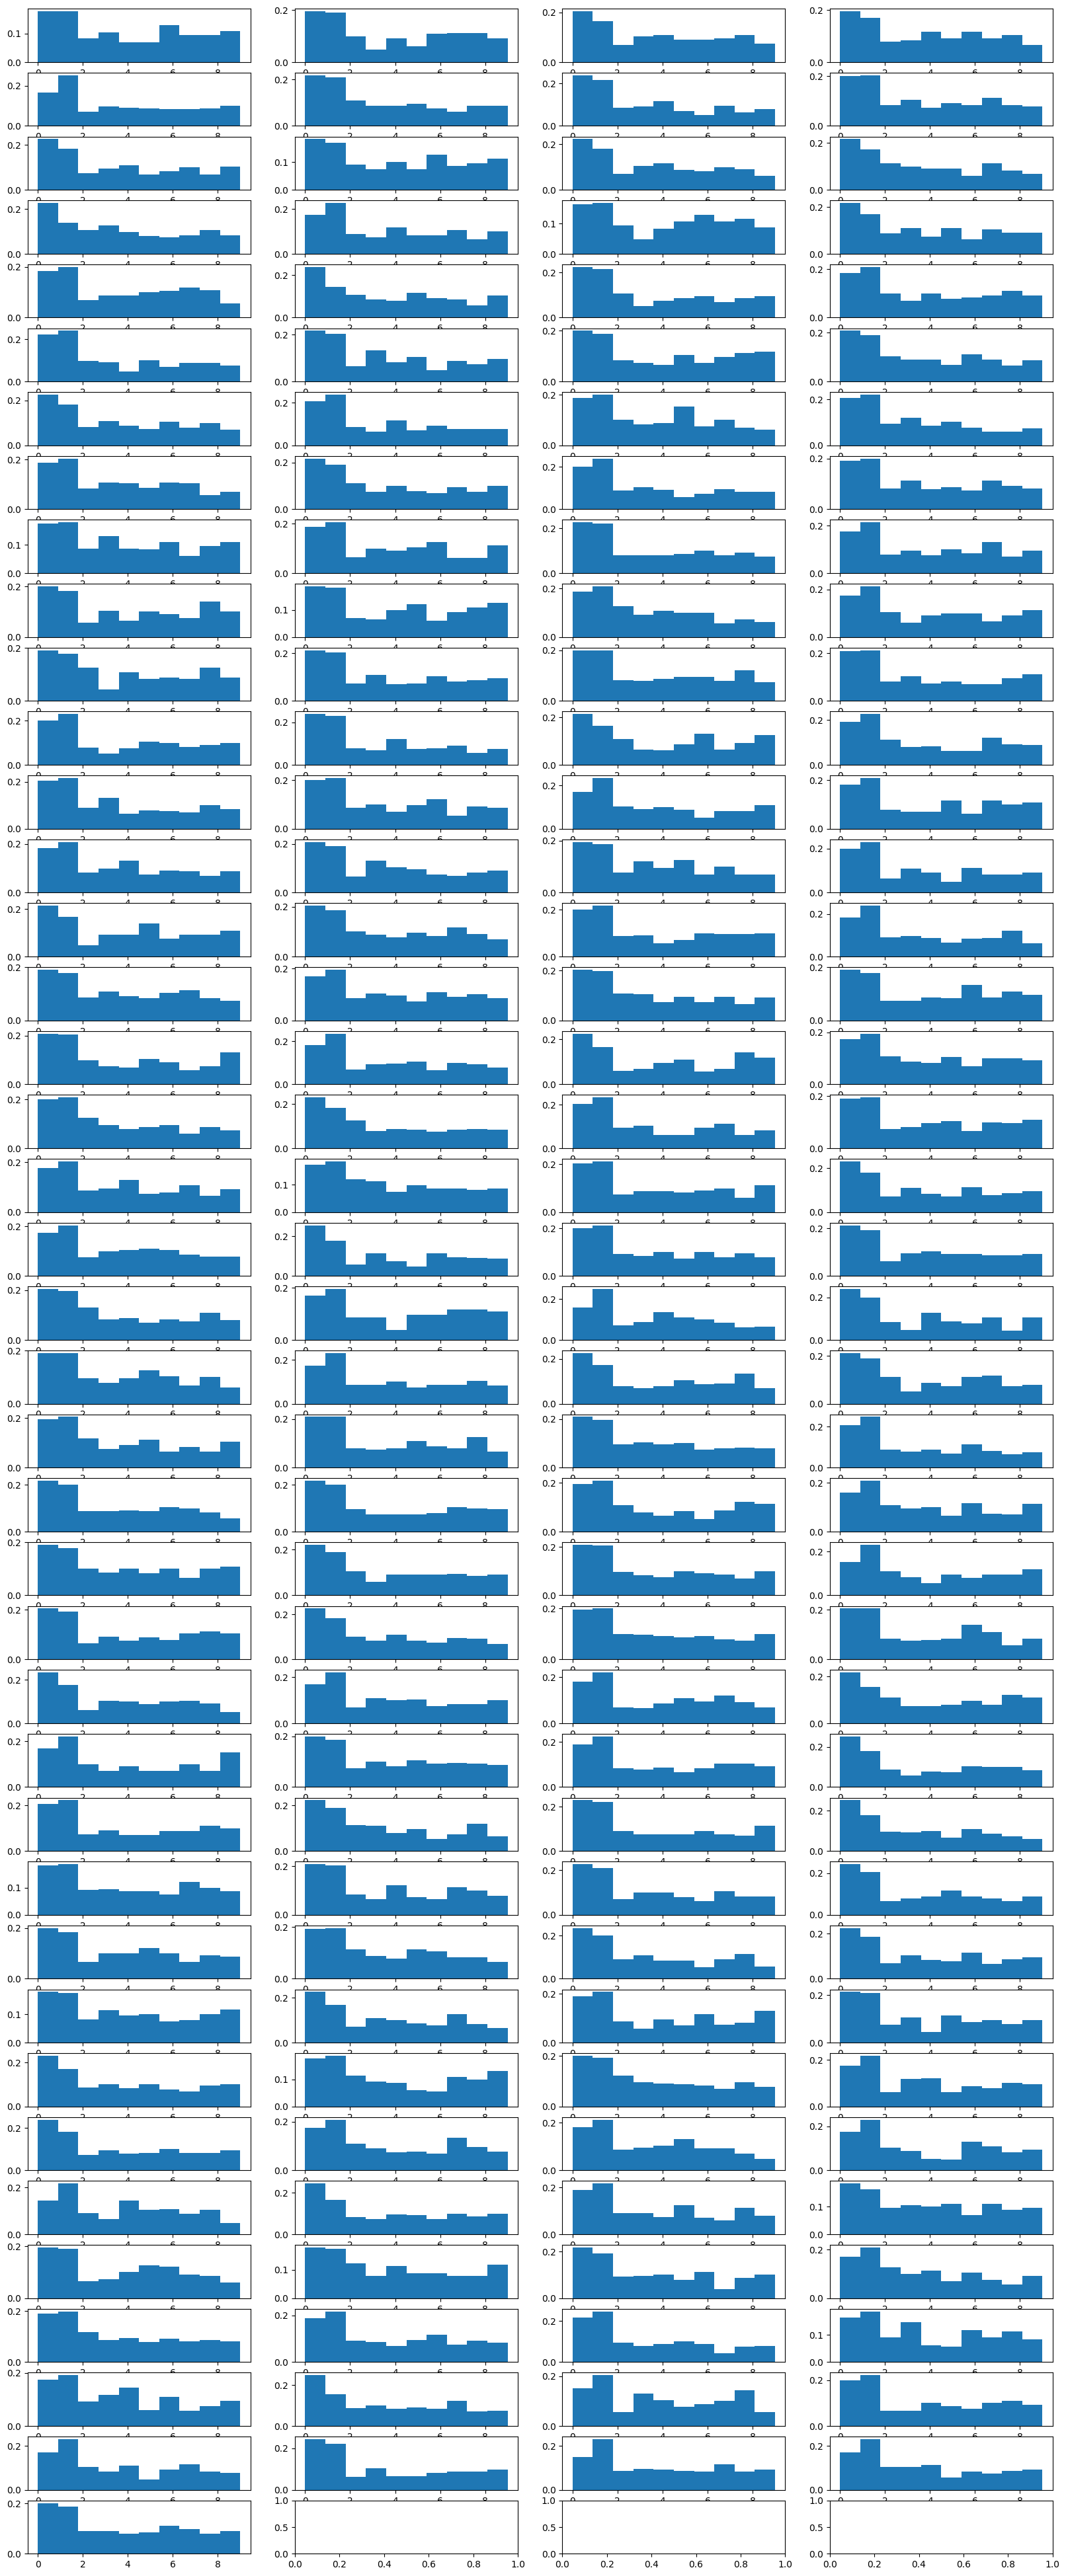

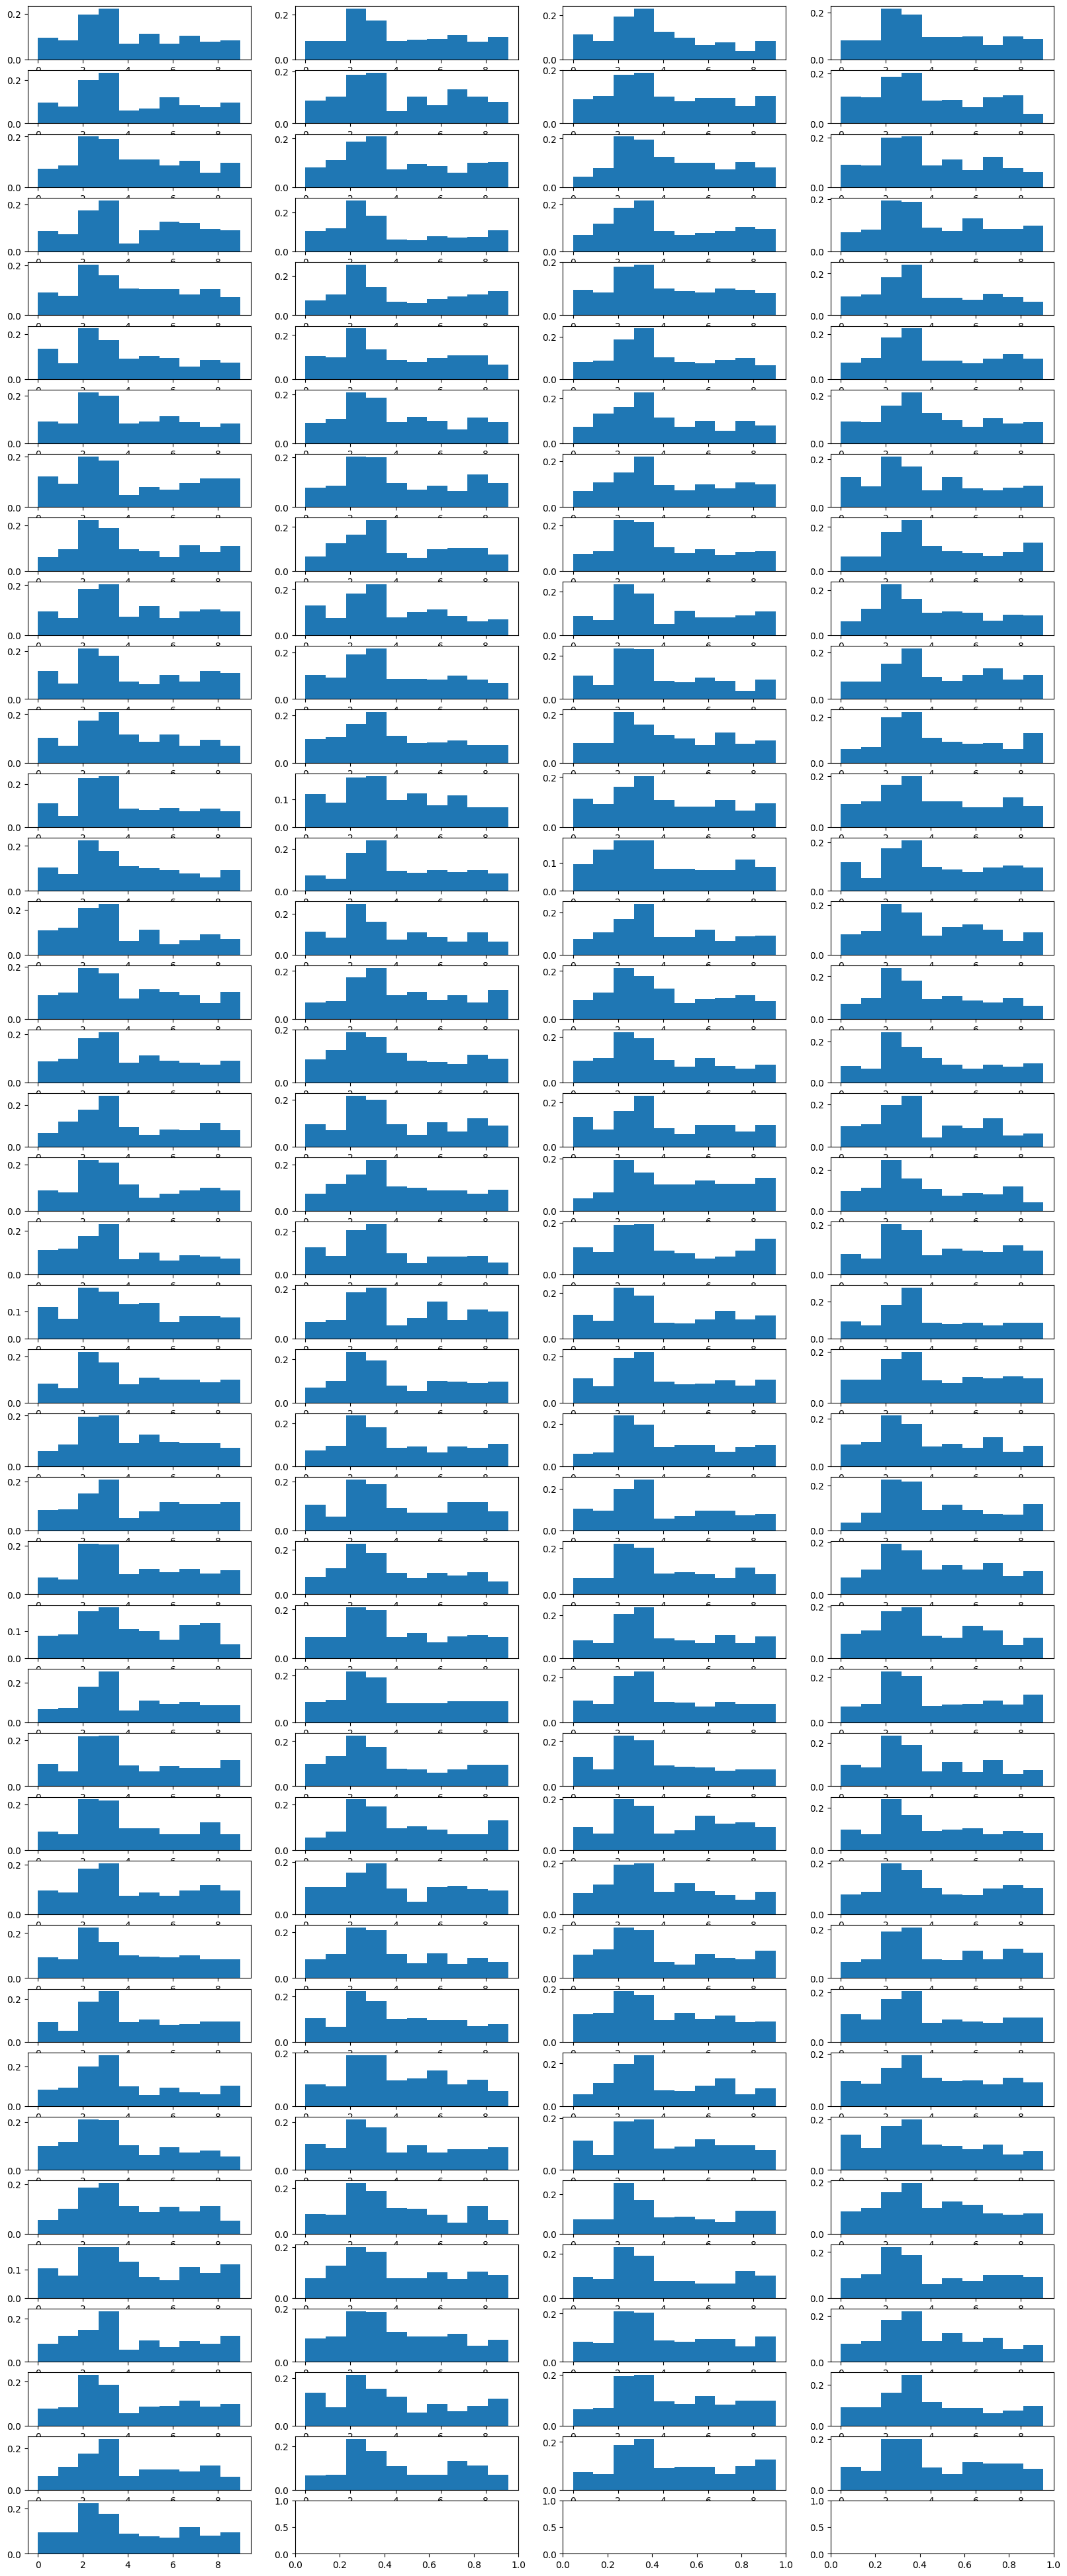

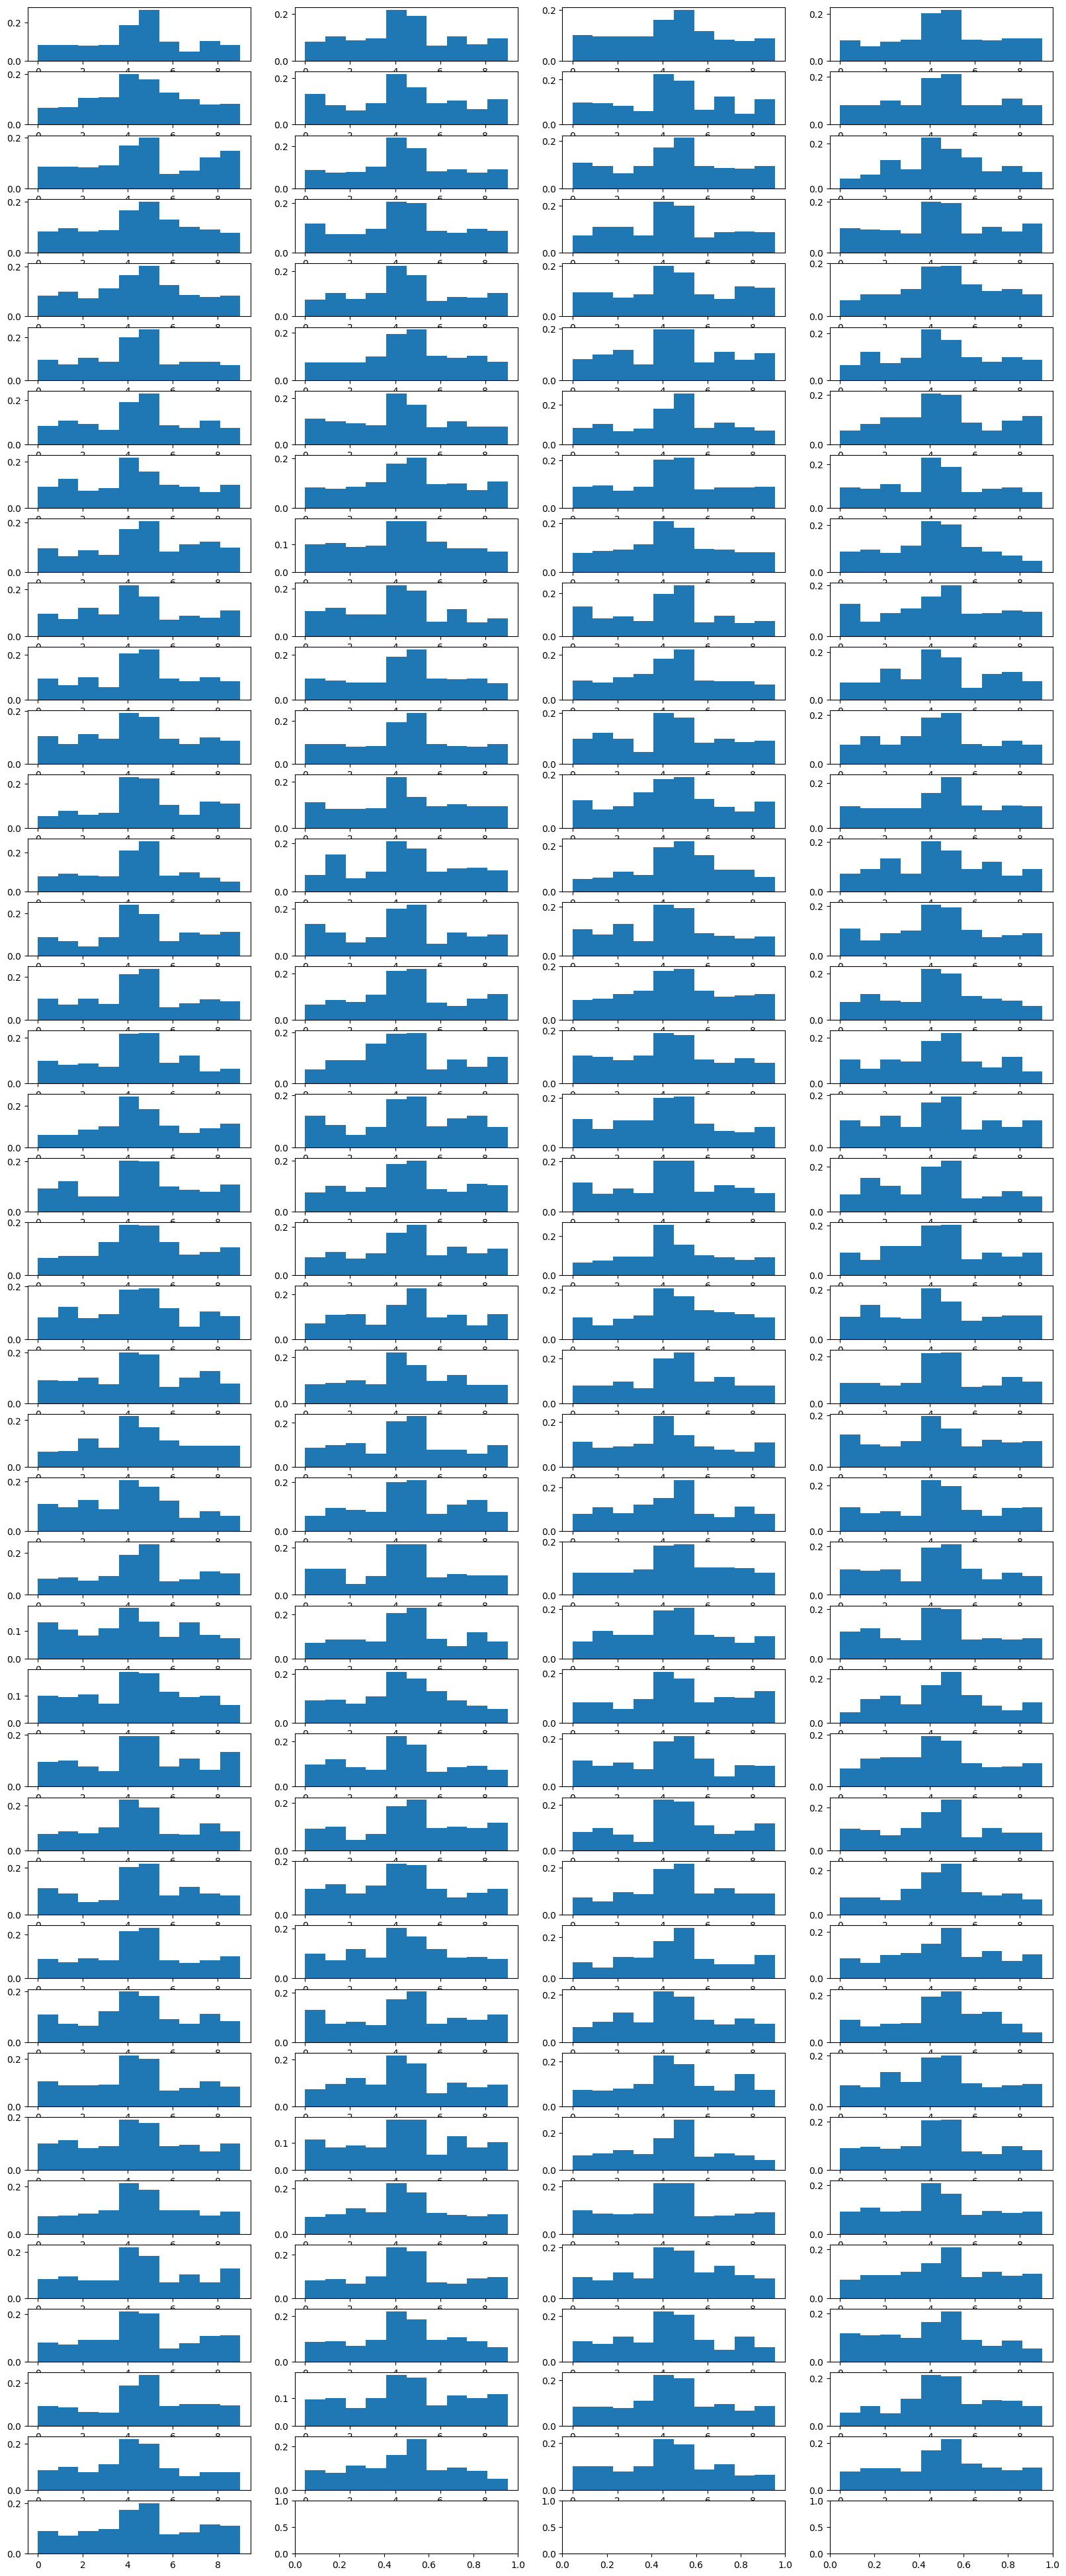

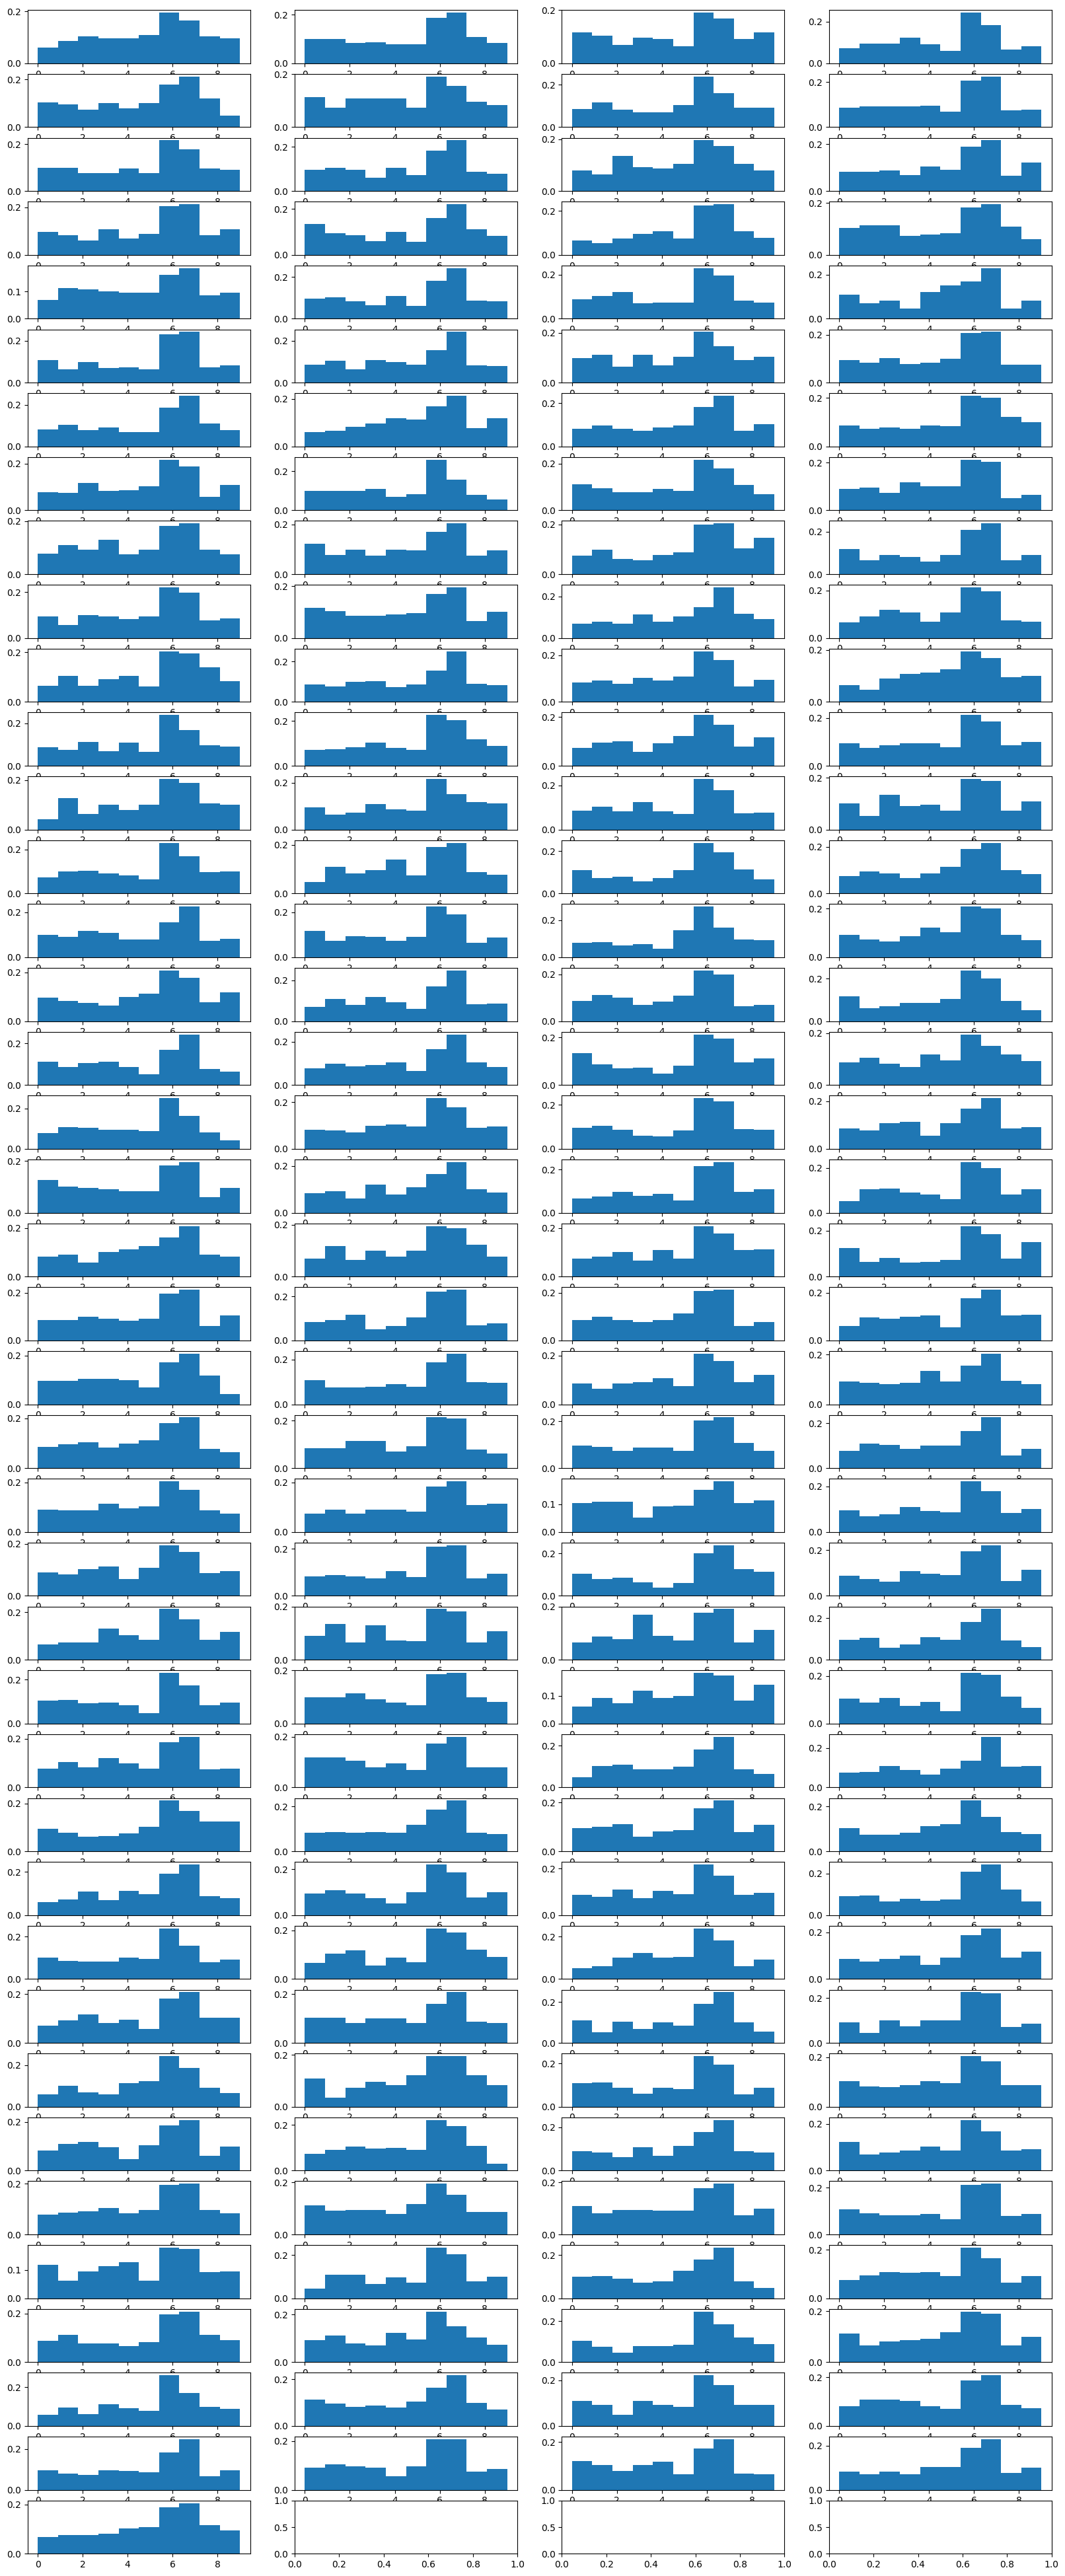

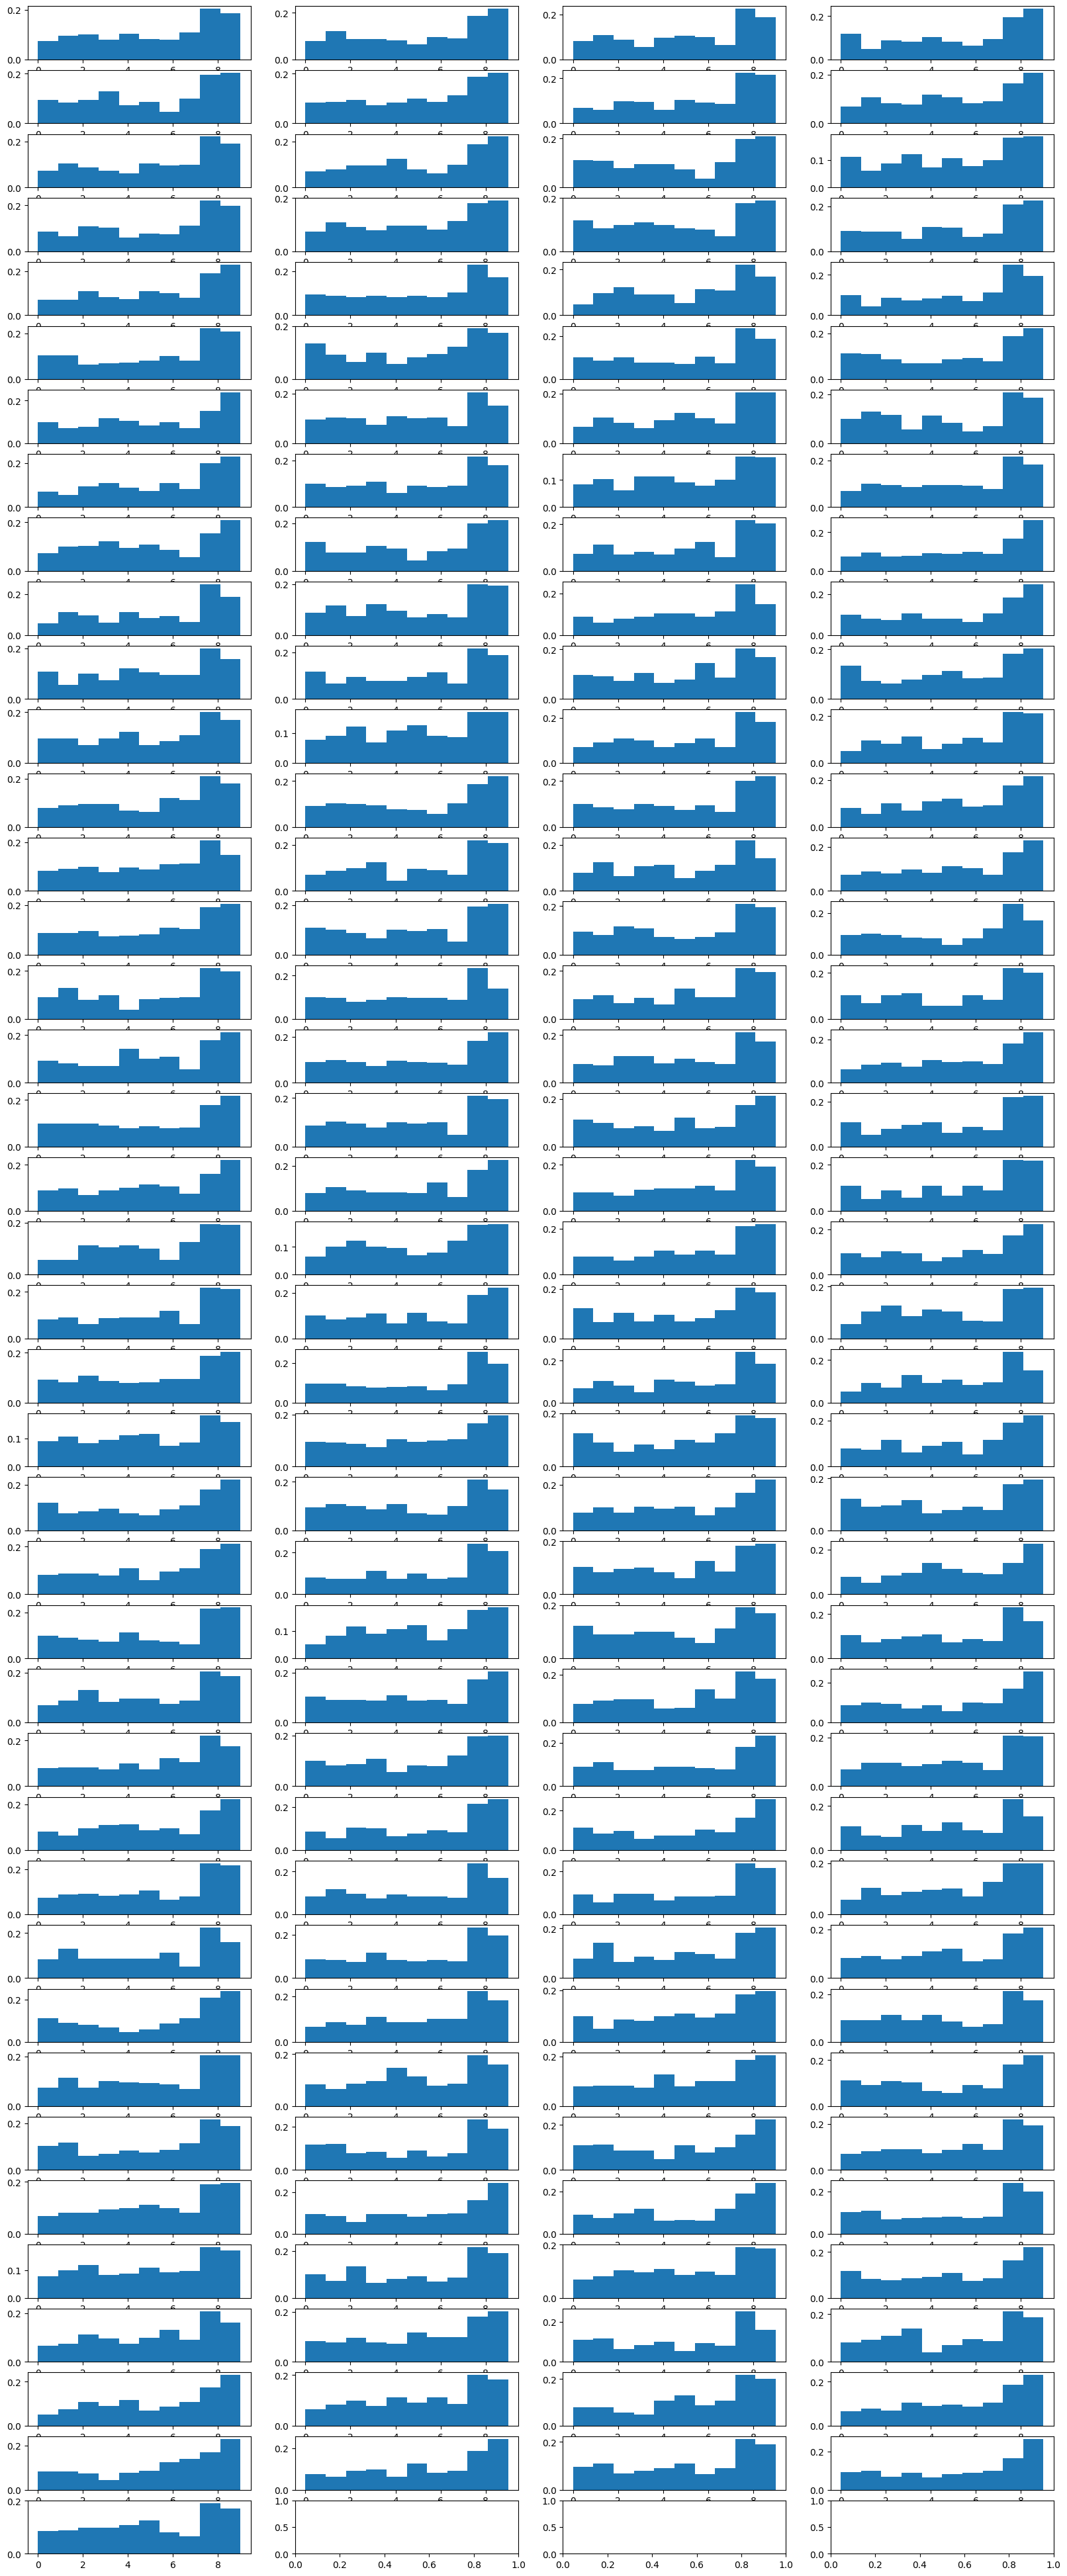

In [157]:
print(len(plugins[1].labels))
for i, batch in enumerate(plugins[1].labels):
    if(i%157 == 0):
        plt.show()
        fig, ax = plt.subplots(40, 4, figsize=(20, 50))
        a, b = (0, 0)
    # We plot a bar chart of the labels in the batch
    ax[b, a].hist(batch, density=True)
    a += 1
    if a == 4:
        a = 0
        b += 1